# Preprocess datasets

In this notebook, we prepare the datasets used by our model

## 1. Get data from Kaggle

Before running:

1. Make sure you had your Kaggle credentials configured correctly:
- [Configuring Kaggle API - Python](https://www.kaggle.com/code/donkeys/kaggle-python-api/notebook)

2. Make sure you accept the rules for the [project](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/rules) (otherwise you won't be able to download the daset)


### Data

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile
import pandas as pd

In [2]:
api = KaggleApi()
api.authenticate()


In [3]:
WORKSPACE = f"{api.get_default_download_dir()}/competitions"
COMPETITION_NAME = 'sentiment-analysis-on-movie-reviews'

In [4]:
api.competition_download_files(competition=COMPETITION_NAME, force=True)
with zipfile.ZipFile(f"{WORKSPACE}/{COMPETITION_NAME}/{COMPETITION_NAME}.zip","r") as zip_ref:
    zip_ref.extractall(f"{WORKSPACE}/{COMPETITION_NAME}")

In [5]:
train_df = pd.read_csv(f'{WORKSPACE}/{COMPETITION_NAME}/train.tsv.zip', sep='\t')
test_df = pd.read_csv(f'{WORKSPACE}/{COMPETITION_NAME}/test.tsv.zip', sep='\t')

train_df.shape, test_df.shape

((156060, 4), (66292, 3))

In [6]:
train_df.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment
116460,116461,6210,to have gone into recruiting the right bands f...,1
76636,76637,3941,the paranoid claustrophobia of a submarine mov...,4
5860,5861,234,yes,2
37485,37486,1780,anyone who is not a character in this movie sh...,2
105078,105079,5550,dishes,2
23680,23681,1075,naturalistic,3
112131,112132,5952,drama and lyricism,2
39335,39336,1878,Gooding and,2
52175,52176,2577,off-beat project,2
14486,14487,625,Better than the tepid Star Trek :,3


## 2. Clean datasets

In [7]:
# Clean duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

(train_df.shape, test_df.shape)

((156060, 4), (66292, 3))

<AxesSubplot: >

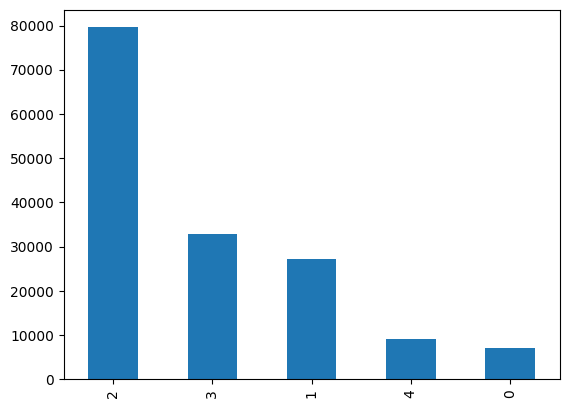

In [8]:
train_df['Sentiment'].value_counts().plot(kind='bar')

## 3. Tokenization (pre-processing)

In [9]:
#!pip3 install tf-nightly


In [33]:
from transformers import BertTokenizer
import pickle
import numpy as np
import tensorflow as tf

In [11]:
SEQ_LEN = 512  # BERT max token length
n_samples = train_df.shape[0]

In [73]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokens = tokenizer(train_df['Phrase'].to_list(), 
                   max_length=SEQ_LEN,
                   truncation=True,
                   padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np'
        )

## 4. Build labels

In [46]:
# Need to arrange labels for the softmax function
labels_values = train_df['Sentiment'].values
labels = np.zeros((n_samples, labels_values.max() + 1))
labels.shape


(156060, 5)

In [49]:
labels[np.arange(n_samples), labels_values] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## 5. Build TensorFlow input dataset

In [75]:
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

In [80]:
def map_data(input_ids, attention_mask, labels):
    return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels

In [77]:
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels))

In [78]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [81]:
dataset = dataset.map(map_data)

In [82]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

## 6. Build train and validation datasets

In [83]:
BATCH_SIZE = 16
SHUFFLE_SIZE = 10000
SPLIT = 0.8

In [84]:
dataset = dataset.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [85]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [86]:
num_train_samples = int(( n_samples / BATCH_SIZE) * SPLIT)
num_train_samples

7803

In [87]:
train_ds = dataset.take(num_train_samples)
test_ds = dataset.skip(num_train_samples)

## 7. Save data

In [88]:
tf.data.Dataset.save(train_ds, 'train')
tf.data.Dataset.save(test_ds, 'test')